# Dropout

In this notebook, you will implement dropout.  Then we will ask you to train a network with batchnorm and dropout, and acheive over 55% accuracy on CIFAR-10.

CS231n has built a solid API for building these modular frameworks and training them, and we will use their very well implemented framework as opposed to "reinventing the wheel."  This includes using their Solver, various utility functions, and their layer structure.  This also includes nndl.fc_net, nndl.layers, and nndl.layer_utils.  As in prior assignments, we thank Serena Yeung & Justin Johnson for permission to use code written for the CS 231n class (cs231n.stanford.edu).  

In [1]:
## Import and setups

import time
import numpy as np
import matplotlib.pyplot as plt
from nndl.fc_net import *
from nndl.layers import *
from cs231n.data_utils import get_CIFAR10_data
from cs231n.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
from cs231n.solver import Solver

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

In [2]:
# Load the (preprocessed) CIFAR10 data.

data = get_CIFAR10_data()
for k in data.keys():
  print('{}: {} '.format(k, data[k].shape))

X_train: (49000, 3, 32, 32) 
y_train: (49000,) 
X_val: (1000, 3, 32, 32) 
y_val: (1000,) 
X_test: (1000, 3, 32, 32) 
y_test: (1000,) 


## Dropout forward pass

Implement the training and test time dropout forward pass, `dropout_forward`, in `nndl/layers.py`. After that, test your implementation by running the following cell.

In [3]:
x = np.random.randn(500, 500) + 10

for p in [0.3, 0.6, 0.75]:
  out, _ = dropout_forward(x, {'mode': 'train', 'p': p})
  out_test, _ = dropout_forward(x, {'mode': 'test', 'p': p})

  print('Running tests with p = ', p)
  print('Mean of input: ', x.mean())
  print('Mean of train-time output: ', out.mean())
  print('Mean of test-time output: ', out_test.mean())
  print('Fraction of train-time output set to zero: ', (out == 0).mean())
  print('Fraction of test-time output set to zero: ', (out_test == 0).mean())

Running tests with p =  0.3
Mean of input:  9.999774747972317
Mean of train-time output:  9.999939281550015
Mean of test-time output:  9.999774747972317
Fraction of train-time output set to zero:  0.700052
Fraction of test-time output set to zero:  0.0
Running tests with p =  0.6
Mean of input:  9.999774747972317
Mean of train-time output:  10.020359212238231
Mean of test-time output:  9.999774747972317
Fraction of train-time output set to zero:  0.398924
Fraction of test-time output set to zero:  0.0
Running tests with p =  0.75
Mean of input:  9.999774747972317
Mean of train-time output:  9.997865195245604
Mean of test-time output:  9.999774747972317
Fraction of train-time output set to zero:  0.250188
Fraction of test-time output set to zero:  0.0


## Dropout backward pass

Implement the backward pass, `dropout_backward`, in `nndl/layers.py`.  After that, test your gradients by running the following cell:

In [4]:
x = np.random.randn(10, 10) + 10
dout = np.random.randn(*x.shape)

dropout_param = {'mode': 'train', 'p': 0.8, 'seed': 123}
out, cache = dropout_forward(x, dropout_param)
dx = dropout_backward(dout, cache)
dx_num = eval_numerical_gradient_array(lambda xx: dropout_forward(xx, dropout_param)[0], x, dout)

print('dx relative error: ', rel_error(dx, dx_num))

dx relative error:  5.445612040627038e-11


## Implement a fully connected neural network with dropout layers

Modify the `FullyConnectedNet()` class in `nndl/fc_net.py` to incorporate dropout.  A dropout layer should be incorporated after every ReLU layer.  Concretely, there shouldn't be a dropout at the output layer since there is no ReLU at the output layer. You will need to modify the class in the following areas:

(1) In the forward pass, you will need to incorporate a dropout layer after every relu layer.

(2) In the backward pass, you will need to incorporate a dropout backward pass layer.

Check your implementation by running the following code.  Our W1 gradient relative error is on the order of 1e-6 (the largest of all the relative errors).

In [9]:
N, D, H1, H2, C = 2, 15, 20, 30, 10
X = np.random.randn(N, D)
y = np.random.randint(C, size=(N,))

for dropout in [0, 0.25, 0.5]:
  print('Running check with dropout = ', dropout)
  model = FullyConnectedNet([H1, H2], input_dim=D, num_classes=C,
                            weight_scale=5e-2, dtype=np.float64,
                            dropout=dropout, seed=123)

  loss, grads = model.loss(X, y)
  print('Initial loss: ', loss)

  for name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    grad_num = eval_numerical_gradient(f, model.params[name], verbose=False, h=1e-5)
    print('{} relative error: {}'.format(name, rel_error(grad_num, grads[name])))
  print('\n')

Running check with dropout =  0
Initial loss:  2.303043161170242
W1 relative error: 4.795196815215288e-07
W2 relative error: 1.9717710574314515e-07
W3 relative error: 1.5587099483501822e-07
b1 relative error: 2.033615448560775e-08
b2 relative error: 1.686315567518667e-09
b3 relative error: 1.1144421861081857e-10


Running check with dropout =  0.25
Initial loss:  2.302354247831908
W1 relative error: 1.0017417771677944e-07
W2 relative error: 2.2591349991943916e-09
W3 relative error: 2.5553916704768502e-05
b1 relative error: 9.368619593647787e-10
b2 relative error: 0.2134290559158092
b3 relative error: 1.2466815697171467e-10


Running check with dropout =  0.5
Initial loss:  2.304242617164796
W1 relative error: 1.207883539101674e-07
W2 relative error: 2.4541280438139708e-08
W3 relative error: 8.057428154752603e-07
b1 relative error: 2.276255983500775e-08
b2 relative error: 6.836023983491334e-10
b3 relative error: 1.2833211144563337e-10




## Dropout as a regularizer

In class, we claimed that dropout acts as a regularizer by effectively bagging.  To check this, we will train two small networks, one with dropout and one without dropout.  

In [10]:
# Train two identical nets, one with dropout and one without

num_train = 500
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

solvers = {}
dropout_choices = [0, 0.6]
for dropout in dropout_choices:
  model = FullyConnectedNet([100, 100, 100], dropout=dropout)

  solver = Solver(model, small_data,
                  num_epochs=25, batch_size=100,
                  update_rule='adam',
                  optim_config={
                    'learning_rate': 5e-4,
                  },
                  verbose=True, print_every=100)
  solver.train()
  solvers[dropout] = solver

(Iteration 1 / 125) loss: 2.300804
(Epoch 0 / 25) train acc: 0.220000; val_acc: 0.168000
(Epoch 1 / 25) train acc: 0.188000; val_acc: 0.147000
(Epoch 2 / 25) train acc: 0.266000; val_acc: 0.200000
(Epoch 3 / 25) train acc: 0.338000; val_acc: 0.262000
(Epoch 4 / 25) train acc: 0.378000; val_acc: 0.278000
(Epoch 5 / 25) train acc: 0.428000; val_acc: 0.297000
(Epoch 6 / 25) train acc: 0.468000; val_acc: 0.323000
(Epoch 7 / 25) train acc: 0.494000; val_acc: 0.287000
(Epoch 8 / 25) train acc: 0.566000; val_acc: 0.328000
(Epoch 9 / 25) train acc: 0.572000; val_acc: 0.322000
(Epoch 10 / 25) train acc: 0.622000; val_acc: 0.324000
(Epoch 11 / 25) train acc: 0.670000; val_acc: 0.279000
(Epoch 12 / 25) train acc: 0.710000; val_acc: 0.338000
(Epoch 13 / 25) train acc: 0.746000; val_acc: 0.319000
(Epoch 14 / 25) train acc: 0.792000; val_acc: 0.307000
(Epoch 15 / 25) train acc: 0.834000; val_acc: 0.297000
(Epoch 16 / 25) train acc: 0.876000; val_acc: 0.327000
(Epoch 17 / 25) train acc: 0.886000; val

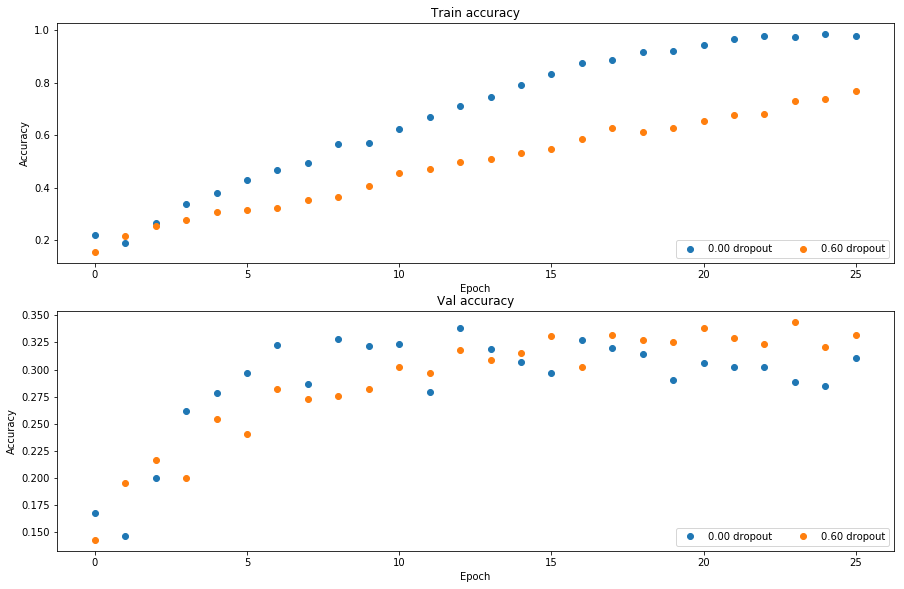

In [11]:
# Plot train and validation accuracies of the two models

train_accs = []
val_accs = []
for dropout in dropout_choices:
  solver = solvers[dropout]
  train_accs.append(solver.train_acc_history[-1])
  val_accs.append(solver.val_acc_history[-1])

plt.subplot(3, 1, 1)
for dropout in dropout_choices:
  plt.plot(solvers[dropout].train_acc_history, 'o', label='%.2f dropout' % dropout)
plt.title('Train accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(ncol=2, loc='lower right')
  
plt.subplot(3, 1, 2)
for dropout in dropout_choices:
  plt.plot(solvers[dropout].val_acc_history, 'o', label='%.2f dropout' % dropout)
plt.title('Val accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(ncol=2, loc='lower right')

plt.gcf().set_size_inches(15, 15)
plt.show()

## Question

Based off the results of this experiment, is dropout performing regularization?  Explain your answer.

## Answer:
Yes, dropout is performing regularization. Regularization is meant to prevent overfitting, which is often shown when the training accuracy is very high. As shown in this experiment, while dropout reduced the training accuracy, it outperformed the baseline model in validation accuracy as the number of epochs grew. This shows that dropout is increasing the generalizability of the model.

## Final part of the assignment

Get over 55% validation accuracy on CIFAR-10 by using the layers you have implemented.  You will be graded according to the following equation:

min(floor((X - 32%)) / 28%, 1) 
where if you get 60% or higher validation accuracy, you get full points.

In [53]:
# ================================================================ #
# YOUR CODE HERE:
#   Implement a FC-net that achieves at least 55% validation accuracy
#   on CIFAR-10.
# ================================================================ #

model = FullyConnectedNet([500, 500, 500], weight_scale=0.01, reg=0.005)
solver = Solver(model, data,
                num_epochs=10, batch_size=200,
                update_rule='adam',
                optim_config={
                    'learning_rate': 1e-4
                },
                verbose=False)
solver.train()
print(solver.best_val_acc)

# ================================================================ #
# END YOUR CODE HERE
# ================================================================ #


0.559


In [ ]:
# Below are the relevant code sections for this part
'''
def dropout_forward(x, dropout_param):
    """
    Performs the forward pass for (inverted) dropout.

    Inputs:
    - x: Input data, of any shape
    - dropout_param: A dictionary with the following keys:
      - p: Dropout parameter. We drop each neuron output with probability p.
      - mode: 'test' or 'train'. If the mode is train, then perform dropout;
        if the mode is test, then just return the input.
      - seed: Seed for the random number generator. Passing seed makes this
        function deterministic, which is needed for gradient checking but not in
        real networks.

    Outputs:
    - out: Array of the same shape as x.
    - cache: A tuple (dropout_param, mask). In training mode, mask is the dropout
      mask that was used to multiply the input; in test mode, mask is None.
    """
    p, mode = dropout_param['p'], dropout_param['mode']
    if 'seed' in dropout_param:
        np.random.seed(dropout_param['seed'])

    mask = None
    out = None

    if mode == 'train':
        # ================================================================ #
        # YOUR CODE HERE:
        #   Implement the inverted dropout forward pass during training time.
        #   Store the masked and scaled activations in out, and store the
        #   dropout mask as the variable mask.
        # ================================================================ #
        mask = (np.random.rand(*x.shape) < p) / p
        out = x * mask
        # ================================================================ #
        # END YOUR CODE HERE
        # ================================================================ #

    elif mode == 'test':
        # ================================================================ #
        # YOUR CODE HERE:
        #   Implement the inverted dropout forward pass during test time.
        # ================================================================ #
        out = x
        # ================================================================ #
        # END YOUR CODE HERE
        # ================================================================ #

    cache = (dropout_param, mask)
    out = out.astype(x.dtype, copy=False)

    return out, cache


def dropout_backward(dout, cache):
    """
    Perform the backward pass for (inverted) dropout.

    Inputs:
    - dout: Upstream derivatives, of any shape
    - cache: (dropout_param, mask) from dropout_forward.
    """
    dropout_param, mask = cache
    mode = dropout_param['mode']

    dx = None
    if mode == 'train':
        # ================================================================ #
        # YOUR CODE HERE:
        #   Implement the inverted dropout backward pass during training time.
        # ================================================================ #
        dx = dout * mask
        # ================================================================ #
        # END YOUR CODE HERE
        # ================================================================ #
    elif mode == 'test':
        # ================================================================ #
        # YOUR CODE HERE:
        #   Implement the inverted dropout backward pass during test time.
        # ================================================================ #
        dx = dout
        # ================================================================ #
        # END YOUR CODE HERE
        # ================================================================ #
    return dx
    
    
        # ================================================================ #
    # YOUR CODE HERE:
    #   Initialize all parameters of the network in the self.params dictionary.
    #   The weights and biases of layer 1 are W1 and b1; and in general the 
    #   weights and biases of layer i are Wi and bi. The
    #   biases are initialized to zero and the weights are initialized
    #   so that each parameter has mean 0 and standard deviation weight_scale.
    #
    #   BATCHNORM: Initialize the gammas of each layer to 1 and the beta
    #   parameters to zero.  The gamma and beta parameters for layer 1 should
    #   be self.params['gamma1'] and self.params['beta1'].  For layer 2, they
    #   should be gamma2 and beta2, etc. Only use batchnorm if self.use_batchnorm 
    #   is true and DO NOT do batch normalize the output scores.
    # ================================================================ #
    dims = np.hstack([input_dim, hidden_dims, num_classes])
    for i in range(self.num_layers):
        self.params['W'+str(i+1)] = weight_scale * np.random.randn(dims[i], dims[i+1])
        self.params['b'+str(i+1)] = np.zeros(dims[i+1])
        if(self.use_batchnorm == True):
            if(i != self.num_layers - 1):
                self.params['gamma' + str(i+1)] = np.ones(dims[i+1])
                self.params['beta' + str(i+1)] = np.zeros(dims[i+1])

    # ================================================================ #
    # END YOUR CODE HERE
    # ================================================================ #

  def loss(self, X, y=None):
    """
    Compute loss and gradient for the fully-connected net.

    Input / output: Same as TwoLayerNet above.
    """
    X = X.astype(self.dtype)
    mode = 'test' if y is None else 'train'

    # Set train/test mode for batchnorm params and dropout param since they
    # behave differently during training and testing.
    if self.dropout_param is not None:
      self.dropout_param['mode'] = mode   
    if self.use_batchnorm:
      for bn_param in self.bn_params:
        bn_param[mode] = mode

    scores = None
    
    # ================================================================ #
    # YOUR CODE HERE:
    #   Implement the forward pass of the FC net and store the output
    #   scores as the variable "scores".
    #
    #   BATCHNORM: If self.use_batchnorm is true, insert a bathnorm layer
    #   between the affine_forward and relu_forward layers.  You may
    #   also write an affine_batchnorm_relu() function in layer_utils.py.
    #
    #   DROPOUT: If dropout is non-zero, insert a dropout layer after
    #   every ReLU layer.
    # ================================================================ #
    x = X
    cache_list = []
    for i in range(self.num_layers-1):
        if(self.use_batchnorm == True and self.use_dropout == True):
            x, cache = affine_batchnorm_relu_dropout_forward(x, self.params['W' + str(i+1)], self.params['b' + str(i+1)], self.params['gamma' + str(i+1)], self.params['beta' + str(i+1)], self.bn_params[i], self.dropout_param)
        elif(self.use_batchnorm == True):
            x, cache = affine_batchnorm_relu_forward(x, self.params['W' + str(i+1)], self.params['b' + str(i+1)], self.params['gamma' + str(i+1)], self.params['beta' + str(i+1)], self.bn_params[i])
        elif(self.use_dropout == True):
            x, cache = affine_relu_dropout_forward(x, self.params['W' + str(i+1)], self.params['b' + str(i+1)], self.dropout_param)
        else:
            x, cache = affine_relu_forward(x, self.params['W' + str(i+1)], self.params['b' + str(i+1)])
        cache_list.append(cache)
    scores, cache = affine_forward(x, self.params['W' + str(self.num_layers)], self.params['b' + str(self.num_layers)])
    cache_list.append(cache)

    # ================================================================ #
    # END YOUR CODE HERE
    # ================================================================ #
    
    
    # ================================================================ #
    # YOUR CODE HERE:
    #   Implement the backwards pass of the FC net and store the gradients
    #   in the grads dict, so that grads[k] is the gradient of self.params[k]
    #   Be sure your L2 regularization includes a 0.5 factor.
    #
    #   BATCHNORM: Incorporate the backward pass of the batchnorm.
    #
    #   DROPOUT: Incorporate the backward pass of dropout.
    # ================================================================ #
    loss, grad = softmax_loss(scores, y)
    for i in range(self.num_layers):
        w = self.params['W' + str(i+1)]
        loss = loss + (0.5 * self.reg * np.sum(w * w))
    dout, dw, grads['b' + str(self.num_layers)] = affine_backward(grad, cache_list[self.num_layers - 1])
    grads['W' + str(self.num_layers)] = dw + self.reg * self.params['W' + str(self.num_layers)]
    for i in range(self.num_layers - 2, -1, -1):
        if(self.use_batchnorm == True):
            if(self.use_dropout == False):
                dx, dw, grads['b' + str(i+1)], dgamma, dbeta = affine_batchnorm_relu_backward(dout, cache_list[i])
                grads['W' + str(i+1)] = dw + self.reg * self.params['W' + str(i+1)]
                grads['gamma' + str(i+1)] = dgamma
                grads['beta' + str(i+1)] = dbeta
                dout = dx
            else:
                dx, dw, grads, dgamma, dbeta = affine_batchnorm_relu_dropout_backward(dout, cache_list[i])
        else:
            if(self.use_dropout == False):
                dx, dw, grads['b' + str(i+1)] = affine_relu_backward(dout, cache_list[i])
                grads['W' + str(i+1)] = dw + self.reg * self.params['W' + str(i+1)]
                dout = dx
            else:
                dx, dw, grads['b' + str(i+1)] = affine_relu_dropout_backward(dout, cache_list[i])
                grads['W' + str(i+1)] = dw + self.reg * self.params['W' + str(i+1)]
                dout = dx

    # ================================================================ #
    # END YOUR CODE HERE
    # ================================================================ #
    
    
def affine_batchnorm_relu_dropout_forward(x, w, b, gamma, beta, bn_param, dropout_param):
    a, fc_cache = affine_forward(x, w, b)
    c, bn_cache = batchnorm_forward(a, gamma, beta, bn_param)
    d, relu_cache = relu_forward(c)
    out, do_cache = dropout_forward(d, dropout_param)
    cache = (fc_cache, bn_cache, relu_cache, do_cache)
    return out, cache

def affine_batchnorm_relu_dropout_backward(dout, cache):
    fc_cache, bn_cache, relu_cache, do_cache = cache
    da = dropout_backward(dout, do_cache)
    db = relu_backward(da, relu_cache)
    dx, dgamma, dbeta = batchnorm_backward(db, bn_cache)
    dx, dw, db = affine_backward(dx, fc_cache)
    return dx, dw, db, dgamma, dbeta

def affine_relu_dropout_forward(x, w, b, dropout_param):
    a, fc_cache = affine_forward(x, w, b)
    c, relu_cache = relu_forward(a)
    out, do_cache = dropout_forward(c, dropout_param)
    cache = (fc_cache, relu_cache, do_cache)
    return out, cache

def affine_relu_dropout_backward(dout, cache):
    fc_cache, relu_cache, do_cache = cache
    da = dropout_backward(dout, do_cache)
    db = relu_backward(da, relu_cache)
    dx, dw, db = affine_backward(db, fc_cache)
    return dx, dw, db
    
'''